In [84]:
import math

import pandas as pd
import numpy as np

df = pd.read_excel("Data/S1%20File.xlsx")

#cleaning
df.drop(columns=["Average weekday", "Average weekend day"], inplace=True)
df.dropna(inplace=True)

#Lista ordine delle colonne
columns_order = df.columns

#Cambio del valore in Genere 1:Maschio 0:Femmina
df["Gender"] = np.where(df["Gender"] == 2, 1,0)

#Inserita la nuova colonna prima della normalizzazione
df["HADS_Score"] = df["Total anxiety score"] + df["Total Depression score"]
#Normalizzazione
gender = df["Gender"]
id_no = df["ID No"]
df.drop(columns=["Gender", "ID No"], inplace=True)

df = (df - df.mean())/df.std()
df["Gender"] = gender
#df["ID No"] = id_no

#df = df[columns_order]
df.reset_index(drop=True, inplace=True)



In [85]:
#Nuova colonna ansia + depressione = HADS_Score


df.drop(columns=["Total anxiety score", "Total Depression score"], inplace=True)

In [86]:
#Splitting
import random
from random import sample

seed = 2023
random.seed(seed)
training_idx = sample(range(0,df.shape[0]),25)

training = df.iloc[training_idx]
training.reset_index(drop= True, inplace=True)

df.drop(df.index[training_idx],inplace = True)
df.reset_index(drop= True, inplace=True)

validation_idx = sample(range(0,df.shape[0]),20)


validation = df.iloc[validation_idx]
validation.reset_index(drop= True, inplace=True)

df.drop(df.index[validation_idx],inplace = True)
df.reset_index(drop= True, inplace=True)

test = df

Text(0.5, 1.0, 'Elastic-Net Paths')

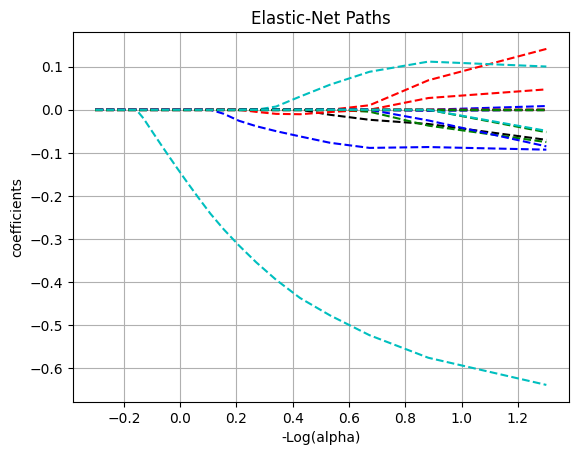

In [87]:
import numpy as np
from sklearn.linear_model import enet_path
y_validation = validation["HADS_Score"]
X_validation = validation.loc[:,validation.columns != "HADS_Score"]

alphas_array = np.linspace(0.05,2,25)
alphas, coefs, _ = enet_path(X_validation, y_validation, alphas= alphas_array, l1_ratio=0.5)


import matplotlib.pyplot as plt
from itertools import cycle

plt.figure(1)
colors = cycle(["b", "r", "g", "c", "k"])

neg_log_alphas = -np.log10(alphas)
for coef, c in zip(coefs, colors):
    l2 = plt.plot(neg_log_alphas, coef, linestyle="--", c=c)
plt.grid()

plt.xlabel("-Log(alpha)")
plt.ylabel("coefficients")
plt.title("Elastic-Net Paths")

In [88]:
from sklearn.linear_model import ElasticNetCV

regr = ElasticNetCV(cv=5, fit_intercept=False,alphas=alphas_array,random_state=seed,l1_ratio = 0.5)
regr.fit(X_validation, y_validation)
print(regr.alpha_)
print(regr.coef_)

0.21250000000000002
[ 0.          0.         -0.          0.         -0.02331394 -0.
  0.01036835 -0.00449798 -0.52298315 -0.         -0.         -0.
 -0.          0.08807415  0.         -0.         -0.         -0.
  0.          0.         -0.08850904 -0.         -0.         -0.        ]


In [89]:
X_colums = list(zip(X_validation.columns,regr.coef_))
print(X_colums)
import math
X_colums_copy = X_colums.copy()
for colum in X_colums_copy:
    if np.isclose(colum[1],0.0):
        X_colums.remove(colum)
X_colums


[('Age', 0.0), ('Height (m)', 0.0), ('Weight (kgs)', -0.0), ('BMI', 0.0), ('working hours per week', -0.023313941394981098), ('RP', -0.0), ('RE', 0.010368354967937522), ('BP', -0.004497984065618171), ('MH', -0.5229831520172246), ('VT', -0.0), ('SF', -0.0), ('PCS', -0.0), ('MCS', -0.0), ('Sitting only', 0.0880741465698163), ('Time standing (h)', 0.0), ('Time stepping (h)', -0.0), ('Step count', -0.0), ('Sit to stand transitions', -0.0), ('Sitting only.1', 0.0), ('Time standing (h).1', 0.0), ('Time stepping (h).1', -0.0885090449724882), ('Step count.1', -0.0), ('Sit to stand transitions.1', -0.0), ('Gender', -0.0)]


[('working hours per week', -0.023313941394981098),
 ('RE', 0.010368354967937522),
 ('BP', -0.004497984065618171),
 ('MH', -0.5229831520172246),
 ('Sitting only', 0.0880741465698163),
 ('Time stepping (h).1', -0.0885090449724882)]

In [90]:
X_colums = [x[0] for x in X_colums]


y_training = training["HADS_Score"]
X_training = training.loc[:,training.columns != "HADS_Score"]
X_training = X_training.loc[:,X_training.columns.isin(X_colums)]
X_training

,working hours per week,RE,BP,MH,Sitting only,Time stepping (h).1
0,0.180008,0.298681,-2.094098,-1.204672,0.079341,-0.067264
1,0.180008,0.298681,-2.094098,1.192380,0.235477,0.590143
2,0.180008,0.298681,0.574851,0.393362,0.155648,0.312923
3,1.152733,0.298681,-2.094098,1.192380,1.742441,-2.094927
4,0.180008,0.298681,0.574851,1.192380,-0.115535,-1.603852
5,0.180008,0.298681,0.574851,1.192380,-1.035914,-0.970207
6,-1.042847,0.298681,0.574851,1.192380,0.173257,0.574301
7,-0.375835,0.298681,0.574851,1.192380,0.069069,1.152502
8,0.180008,0.298681,0.574851,0.393362,-0.701338,-0.550418
9,0.735851,0.298681,0.574851,-2.003689,0.966850,-0.827637


In [92]:
import statsmodels.api as sm

X_training = sm.add_constant(X_training)

In [93]:
model = sm.OLS(y_training, X_training)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:             HADS_Score   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.580
Method:                 Least Squares   F-statistic:                     6.529
Date:                Mon, 27 Nov 2023   Prob (F-statistic):           0.000860
Time:                        11:58:24   Log-Likelihood:                -17.135
No. Observations:                  25   AIC:                             48.27
Df Residuals:                      18   BIC:                             56.80
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0